In [51]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39195 instead
  warnings.warn(


In [52]:
import datacube
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from odc.ui import DcViewer
from datacube.utils import masking
from datacube.utils.rio import configure_s3_access
from dea_tools.plotting import display_map, rgb

configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)
dc = datacube.Datacube(app='Uploading_data')

In [53]:
query = {
    "product": "landsat5_c2l2_sr",
    "y": (-51.05, -50.825), 
    "x":  (-73.375, -73.16),
    "time": ("1984-03-01", "2023-12-31"),
    "output_crs": "EPSG:32719",
    "resolution": (-30, 30),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}

ds = dc.load(**query)

In [54]:
from dea_tools.plotting import display_map, rgb
display_map(x = query['x'], y = query['y'])

In [9]:
datacube.utils.masking.describe_variable_flags(ds)

bits  \
snow                                                               5   
clear                                                              6   
cloud                                                              3   
water                                                              7   
nodata                                                             0   
qa_pixel                 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13]   
cloud_shadow                                                       4   
dilated_cloud                                                      1   
cloud_confidence                                              [8, 9]   
snow_ice_confidence                                         [12, 13]   
cloud_shadow_confidence                                     [10, 11]   

                                                                    values  \
snow                     {'0': 'not_high_confidence', '1': 'high_confid...   
clear                                     {'0': 'not_clear', '1': 'clear'}   
cloud                    {'0': 'not_high_confidence', '1': 'high_confid...   
water                                 {'0': 'land_or_cloud', '1': 'water'}   
nodata                                             {'0': False, '1': True}   
qa_pixel                 {'1': 'Fill', '2': 'Dilated Cloud', '8': 'Clou...   
cloud_shadow             {'0': 'not_high_confidence', '1': 'high_confid...   
dilated_cloud                         {'0': 'not_dilated', '1': 'dilated'}   
cloud_confidence         {'0': 'none', '1': 'low', '2': 'medium', '3': ...   
snow_ice_confidence      {'0': 'none', '1': 'low', '2': 'reserved', '3'...   
cloud_shadow_confidence  {'0': 'none', '1': 'low', '2': 'reserved', '3'...   

                                   description  
snow                                       NaN  
clear                                      NaN  
cloud                                      NaN  
water                                      NaN  
nodata                                     NaN  
qa_pixel                 Level 2 pixel quality  
cloud_shadow                               NaN  
dilated_cloud                              NaN  
cloud_confidence                           NaN  
snow_ice_confidence                        NaN  
cloud_shadow_confidence                    NaN

In [5]:
datacube.utils.masking.describe_variable_flags(ds)["values"]["qa_pixel"]

{'1': 'Fill',
 '2': 'Dilated Cloud',
 '8': 'Cloud',
 '16': 'Cloud Shadow',
 '32': 'Snow',
 '64': 'Clear',
 '128': 'Water',
 '256': 'Cloud Confidence low bit',
 '512': 'Cloud Confidence high bit',
 '1024': 'Cloud Shadow Confidence low bit',
 '2048': 'Cloud Shadow Confidence high bit',
 '4096': 'Snow Ice Confidence low bit',
 '8192': 'Snow Ice Confidence high bit'}

In [6]:
from datacube.utils import masking
bandas_reflectancia = ["blue", "green", "red", "nir08", "swir16", "swir22"]
masking.describe_variable_flags(ds.qa_pixel)

# REVISAR!!!
good_pixel_flags = {
     "cloud": "not_high_confidence",
    #"cloud_shadow": "not_high_confidence",
    #"dilated_cloud": "not_dilated",
    #"cloud_confidence" : "none",
    #"cloud_shadow_confidence": "none",
    "nodata": False
}

In [7]:
quality_band = 'qa_pixel'
cloud_free_mask1 = masking.make_mask(ds[quality_band], **good_pixel_flags)

In [8]:
months = ds['time.month']
#is_summer = (months <= 4) | (months >= 10)

In [9]:
valid_pixel_proportion = cloud_free_mask1.sum(dim=("x", "y"))/(cloud_free_mask1.shape[1] * cloud_free_mask1.shape[2])

valid_threshold = 0.5

observations_to_keep = (valid_pixel_proportion >= valid_threshold) #& is_summer

In [10]:
ds_raw = ds[bandas_reflectancia].where(True)
dsf = ds_raw.where(cloud_free_mask1)
ds_clean = dsf.sel(time=observations_to_keep).persist()
ds_RAW = ds_raw.sel(time=observations_to_keep).persist()

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [11]:
print(f'Images uploaded with DataCube: {len(ds["time"])}')
print(f'Images that pass the filters: {len(ds_clean["time"])}')

Images uploaded with DataCube: 219
Images that pass the filters: 65


/env/lib/python3.10/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


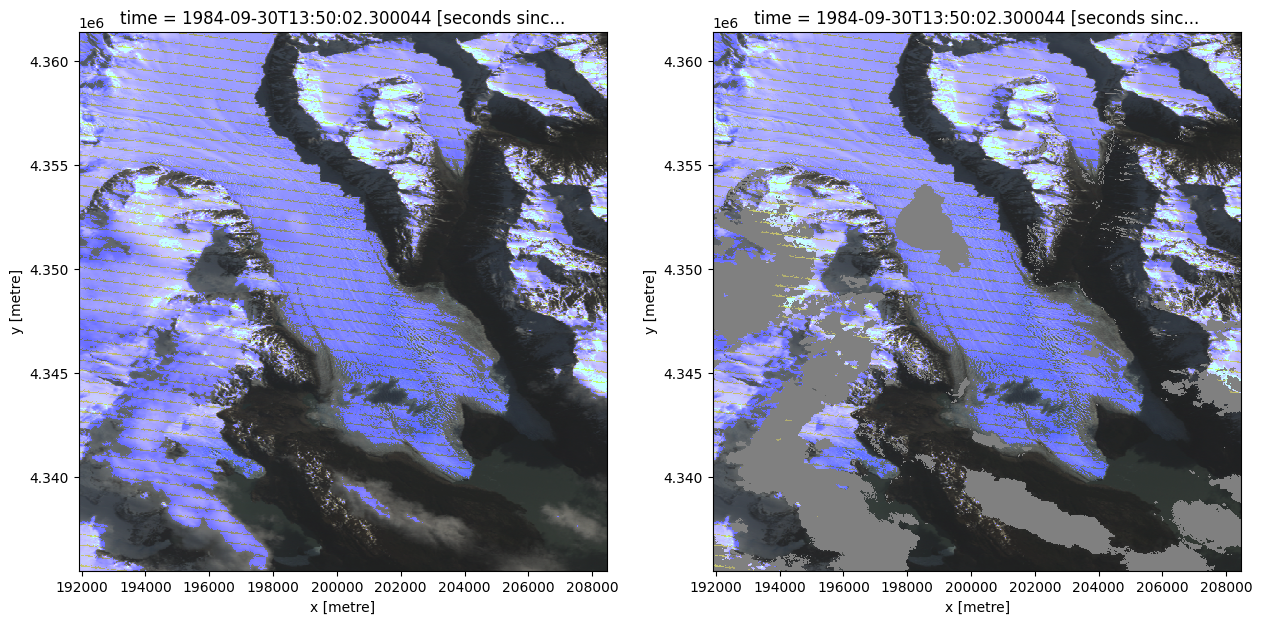

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
n_img = 0
img = ds_RAW[["red", "green", "blue"]].isel(time=n_img).squeeze().to_array()
img.plot.imshow(vmin=0, vmax=np.percentile(img, 90), robust=True, ax = ax[0])
ds_clean[["red", "green", "blue"]].isel(time=n_img).squeeze().to_array().plot.imshow(vmin=0, vmax=np.percentile(img, 90), robust=True, ax = ax[1])
ax[1].set_facecolor("grey")

In [13]:
ds_clean_norm = (ds_clean * 0.0000275 + -0.2)
ds_RAW_norm = (ds_RAW * 0.0000275 + -0.2)
ds_clean_norm = ds_clean_norm#.where(ds_clean_norm >= 0).where(ds_clean_norm <= 1).compute()
ds_RAW_norm = ds_RAW_norm#.where(ds_RAW_norm >= 0).where(ds_RAW_norm <= 1).compute()

ds_SnowID_clean = ((ds_clean_norm['green'] - ds_clean_norm['swir16']) / (ds_clean_norm['green'] + ds_clean_norm['swir16'])).compute()
ds_SnowID_clean.attrs = ds_clean_norm['red'].attrs

ds_SnowID_RAW = ((ds_RAW_norm['green'] - ds_RAW_norm['swir16']) / (ds_RAW_norm['green'] + ds_RAW_norm['swir16'])).compute()
ds_SnowID_RAW.attrs = ds_RAW_norm['red'].attrs

In [14]:
ds_SnowID_clean = ds_SnowID_clean.where(ds_SnowID_clean > 0.7).compute().where(ds_clean_norm['blue'] > 0.2).compute()
ds_SnowID_RAW = ds_SnowID_RAW.where(ds_SnowID_RAW > 0.7).compute().where(ds_RAW_norm['blue'] > 0.2).compute()

/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 118.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 118.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


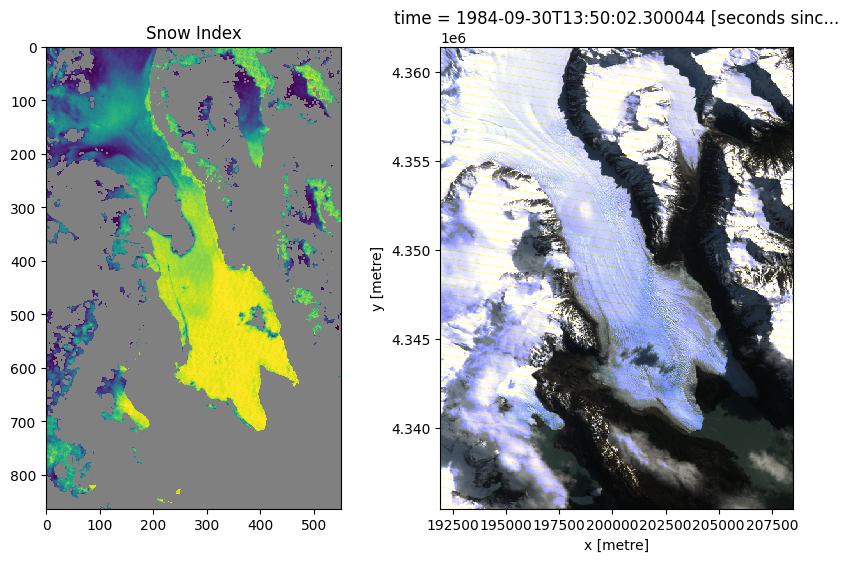

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios':[1,1], 'height_ratios':[1]})

n_img = 0

img = ds_SnowID_RAW.isel(time=n_img)
ax[0].imshow(img, cmap='viridis', vmin=np.nanpercentile(img, 5), vmax=np.nanpercentile(img, 95))
ax[0].set_title('Snow Index')
ax[0].set_facecolor("grey")
ax[0].set_facecolor("grey")

RGB_array = ds_RAW_norm[["red", "green", "blue"]].isel(time=n_img).to_array()
RGB_array.plot.imshow(vmin=0, vmax=1, ax=ax[1])
ax[1].set_facecolor("grey")

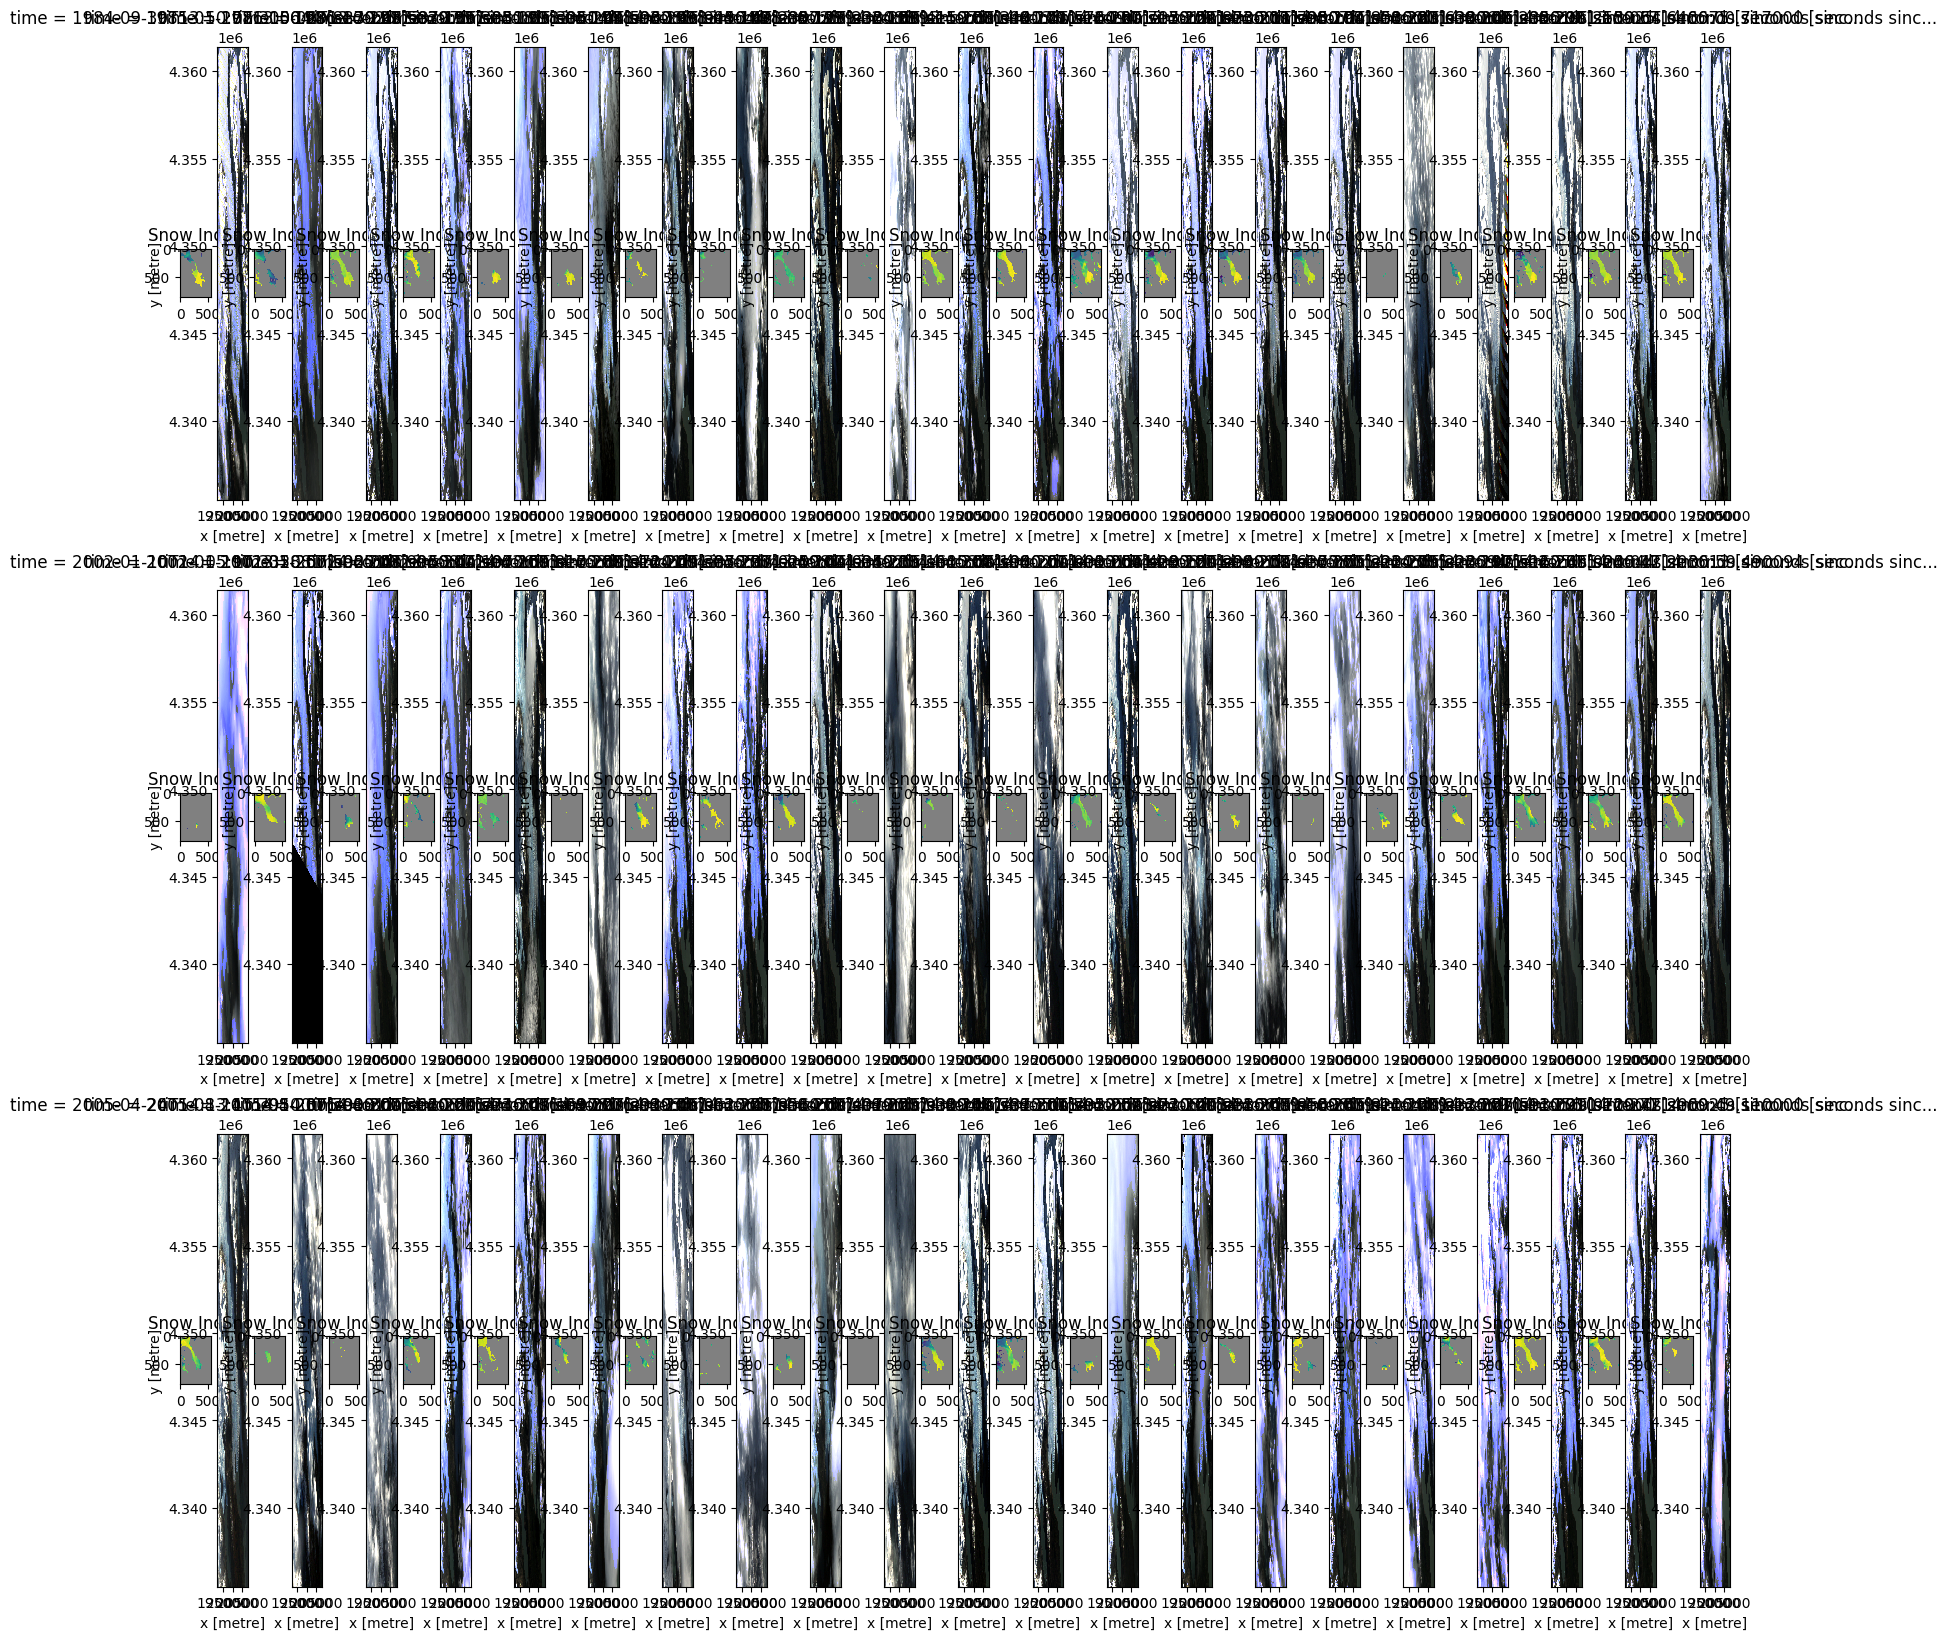

In [16]:
#Parametros del grafico
T = len(ds_SnowID_RAW['time']) # Numero de imagenes
large_img = 20                 # Tamano de la imagen
nx = 3                         # Numero de filas 
ny = T//nx                     # Numero de columnas

len_x = len(ds_SnowID_RAW['x'])
len_y = len(ds_SnowID_RAW['y'])
razon = len_y/len_x
fig, ax = plt.subplots(nx, ny*2, figsize=(np.round(large_img), large_img), gridspec_kw={'width_ratios':[1,1]*ny, 'height_ratios':[1]*nx})

for i in range(nx):
    for j in range(ny):
        img = ds_SnowID_RAW.isel(time=i*ny + j)
        ax[i, j*2].imshow(img, cmap='viridis', vmin=np.nanpercentile(img, 5), vmax=np.nanpercentile(img, 95))
        ax[i, j*2].set_title('Snow Index')
        ax[i, j*2].set_facecolor("grey")
        ax[i, j*2].set_facecolor("grey")

        RGB_array = ds_RAW_norm[["red", "green", "blue"]].isel(time=i*ny+j).to_array()
        RGB_array.plot.imshow(vmin=0, vmax=1, ax=ax[i, j*2+1])
        ax[i, j*2+1].set_facecolor("grey")
        
#plt.savefig('plots/images_used_SI5_B2.png')

In [17]:
ds_RAW_norm.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:      (time: 65, y: 864, x: 552)
Coordinates:
  * time         (time) datetime64[ns] 1984-09-30T13:50:02.300044 ... 2011-10...
  * y            (y) float64 4.361e+06 4.361e+06 ... 4.336e+06 4.335e+06
  * x            (x) float64 1.919e+05 1.92e+05 1.92e+05 ... 2.084e+05 2.085e+05
    spatial_ref  int32 32719
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 864, 552), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 864, 552), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 864, 552), meta=np.ndarray>
    nir08        (time, y, x) float32 dask.array<chunksize=(1, 864, 552), meta=np.ndarray>
    swir16       (time, y, x) float32 dask.array<chunksize=(1, 864, 552), meta=np.ndarray>
    swir22       (time, y, x) float32 dask.array<chunksize=(1, 864, 552), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial

In [18]:
bool_Xarray = ds_SnowID_clean >0

In [19]:
data_filled = ds_clean['red'].where(bool_Xarray, other=1) # no glacier
output = data_filled.where(~bool_Xarray, other=0)  # glacier
string_output = output.where(cloud_free_mask1.sel(time=observations_to_keep), other=2) # other

/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 59.17 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


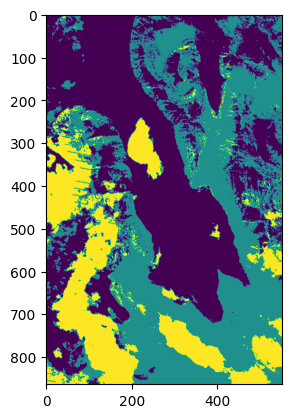

In [20]:
plt.imshow(string_output.isel(time=0).values)

In [21]:
bool_Xarray = ds_SnowID_RAW >0

In [22]:
if 'units' in ds_RAW_norm.time.attrs:
    del ds_RAW_norm.time.attrs['units']
    
if 'units' in string_output.time.attrs:
    del string_output.time.attrs['units']

ds_RAW_norm['red'].to_netcdf("datos_training/RED_LANDSAT5.nc")
ds_RAW_norm['green'].to_netcdf("datos_training/GREEN_LANDSAT5.nc")
ds_RAW_norm['blue'].to_netcdf("datos_training/BLUE_LANDSAT5.nc")
ds_RAW_norm['nir08'].to_netcdf("datos_training/NIR_LANDSAT5.nc")
string_output.to_netcdf("datos_training/BOOL_LANDSAT5.nc")


/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 59.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [23]:
red_values = []
green_values = []
blue_values = []
nir_values = []
bool_values = []

for t, time in enumerate(ds_RAW_norm['time']):
    red = ds_RAW_norm['red'].sel(time=time).squeeze().values.ravel().tolist()
    green = ds_RAW_norm['green'].sel(time=time).squeeze().values.ravel().tolist()
    blue = ds_RAW_norm['blue'].sel(time=time).squeeze().values.ravel().tolist()
    nir = ds_RAW_norm['nir08'].sel(time=time).squeeze().values.ravel().tolist()
    is_glacier = (ds_SnowID_RAW.sel(time=time) > 0).squeeze().values.ravel().tolist()
    bool_values += is_glacier
    red_values += red
    green_values += green
    blue_values += blue
    nir_values += nir

In [24]:
data = {'red': red_values,
        'green': green_values,
        'blue': blue_values,
        'nir': nir_values, 
        'glacier': bool_values}

df = pd.DataFrame(data)

In [27]:
df.head()

red     green      blue       nir  glacier
0  0.784445  0.805813  1.602212  0.750923     True
1  0.740088  0.773170  1.602212  0.698535     True
2  0.680550  0.718307  1.602212  0.616640     True
3  0.720288  0.751308  1.602212  0.675215     True
4  0.754910  0.778670  0.587545  0.716053     True

In [26]:
df.to_csv('datos_training/landsat5.csv')
pix_glacier = np.sum(df['glacier'])/len(df)
print(f'Porcentaje de pixeles que correspondena a glaciar: {pix_glacier*100}%')

Porcentaje de pixeles que correspondena a glaciar: 35.94113544634378%


In [21]:
from pyproj import Proj
crs = ds.crs
P = Proj(crs)

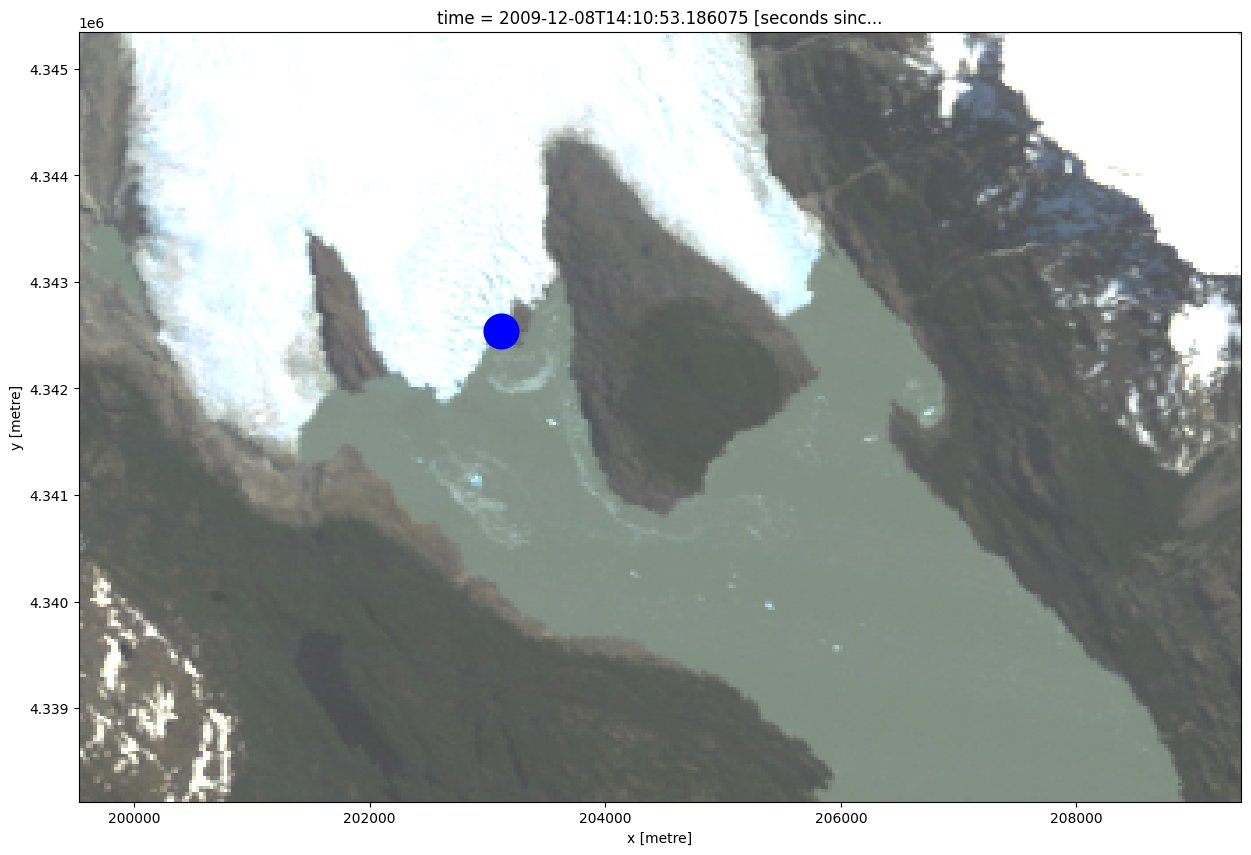

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))

x, y = P(-73.231, -50.992)

t = '2009-12-08T14:10:53.186075'
img =  ds[["red", "green", "blue"]].sel(time=t).to_array()
#ax.plot(203000, 4.3423*10**6, '.', color='red', markersize=50)
ax.plot(x, y, '.', color='blue', markersize=50)
(img/np.nanpercentile(img, 80)).plot.imshow(vmin=0, vmax=1, ax=ax)
ax.set_facecolor("grey")
plt.show()